In [2]:
import sys
sys.path.append('/Users/jdli/Project/kurucz1/')
import torch
from kuruczone import emulator

# Load pre-trained model
device = torch.device("mps")

model = emulator.load_from_checkpoint("../model/a_one_weights.pt", device=device)

# Move model to the appropriate device
# Create stellar parameter inputs
stellar_params = torch.tensor([[5000.0, 4.5, -0.5, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]
stellar_params = stellar_params.to(device)  # Move to the same device as the model
# Create optical depth grid (optional)
tau_grid = torch.logspace(-7, 2, 80).unsqueeze(0)  # Shape: [1, 100]
tau_grid = tau_grid.to(device)  # Move to the same device as the model
# Predict atmospheric structure
atmosphere = model.predict(stellar_params, tau_grid)

# Access variables
temperature = atmosphere['T']  # Shape: [batch_size, n_depth_points]
pressure = atmosphere['P']

/Users/jdli/Project/kurucz1/kuruczone/normalization.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(norm_params_path, map_location='cpu')
/Users/jdli/

Model loaded: trained for 50 epochs, final loss: 7.378867


In [11]:
# model = torch.load("../model/a_one_weights.pt", map_location=device)
# # model
# state_dict = model['model_state_dict']

# total_params = sum(param.numel() for param in state_dict.values())
# total_params

Text(0, 0.5, 'Temperature (K)')

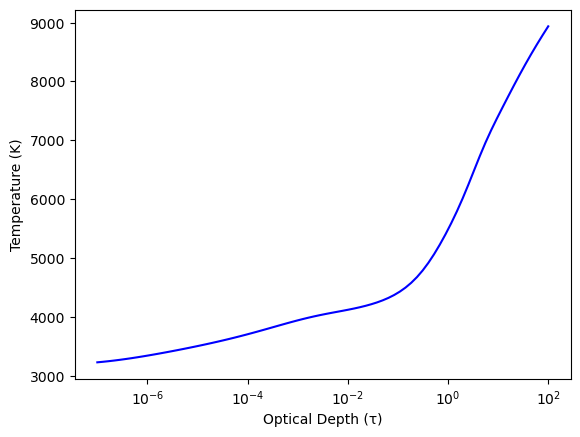

In [5]:
from matplotlib import pyplot as plt
import numpy as np

# Plot temperature profileplt.figure(figsize=(6, 4))
plt.plot(tau_grid[0].cpu(), temperature[0].cpu(), label='Temperature', color='blue')
plt.xscale('log')
plt.xlabel('Optical Depth (τ)')
plt.ylabel('Temperature (K)')

In [6]:
# Create multiple stellar parameter inputs
stellar_params = torch.tensor([
    [5000.0, 4.5, -0.5, 0.0],  # Model 1
    [6000.0, 4.0, 0.0, 0.0],   # Model 2
    [4500.0, 2.5, -1.0, 0.3]    # Model 3
]).to(device)  # Move to the same device as the model
# Predict atmospheric structures for all models
atmospheres = model.predict(stellar_params)

# Access variables for specific models
temperature_model1 = atmospheres['T'][0]  # First model
temperature_model2 = atmospheres['T'][1]  # Second model

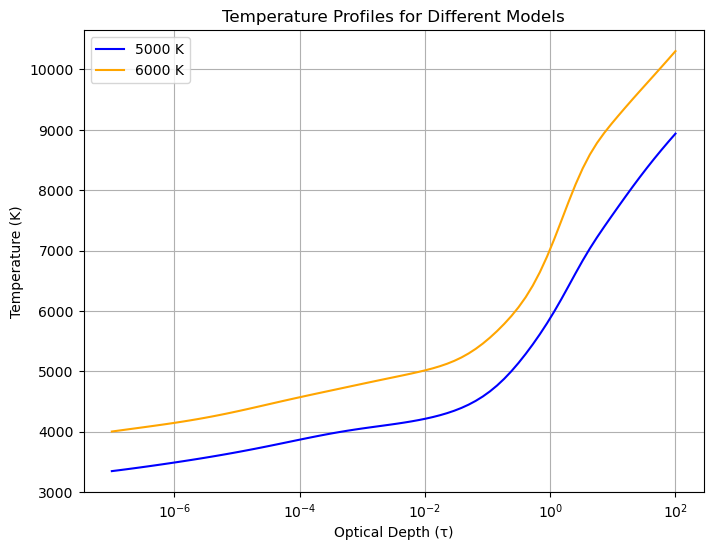

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(tau_grid[0].cpu(), temperature_model1.cpu(), label='5000 K', color='blue')
plt.plot(tau_grid[0].cpu(), temperature_model2.cpu(), label='6000 K', color='orange')
plt.xscale('log')
plt.xlabel('Optical Depth (τ)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.title('Temperature Profiles for Different Models')
plt.grid()
plt.show()      

In [10]:
import time
import numpy as np

def benchmark_inference(model, batch_sizes=[1, 10, 100, 1000, 5000], num_runs=5):
    """
    Benchmark inference time for different batch sizes
    """
    results = {}
    
    for batch_size in batch_sizes:
        print(f"Benchmarking batch size: {batch_size}")
        
        # Create random stellar parameters for the batch
        stellar_params = torch.tensor(np.random.uniform(
            low=[3500, 0.0, -2.5, -0.5],   # Min values for [Teff, log(g), [Fe/H], [α/Fe]]
            high=[8000, 5.0, 0.5, 0.5],    # Max values
            size=(batch_size, 4)
        )).float().to(device)  # Move to the same device as the model
        
        times = []
        
        # Warm-up run
        _ = model.predict(stellar_params)
        
        # Timed runs
        for run in range(num_runs):
            start_time = time.time()
            atmosphere = model.predict(stellar_params)
            end_time = time.time()
            times.append(end_time - start_time)
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        time_per_model = avg_time / batch_size
        
        results[batch_size] = {
            'avg_time': avg_time,
            'std_time': std_time,
            'time_per_model': time_per_model,
            'models_per_second': batch_size / avg_time
        }
        
        print(f"  Average time: {avg_time:.4f} ± {std_time:.4f} seconds")
        print(f"  Time per model: {time_per_model:.6f} seconds")
        print(f"  Models per second: {batch_size/avg_time:.1f}")
        print()
    
    return results

# Run benchmark
benchmark_results = benchmark_inference(model)

Benchmarking batch size: 1
  Average time: 0.0093 ± 0.0052 seconds
  Time per model: 0.009292 seconds
  Models per second: 107.6

Benchmarking batch size: 10
  Average time: 0.4805 ± 0.9337 seconds
  Time per model: 0.048051 seconds
  Models per second: 20.8

Benchmarking batch size: 100
  Average time: 0.0368 ± 0.0064 seconds
  Time per model: 0.000368 seconds
  Models per second: 2720.2

Benchmarking batch size: 1000
  Average time: 0.4057 ± 0.1848 seconds
  Time per model: 0.000406 seconds
  Models per second: 2464.7

Benchmarking batch size: 5000


RuntimeError: MPS backend out of memory (MPS allocated: 18.09 GB, other allocations: 26.73 MB, max allowed: 18.13 GB). Tried to allocate 3.05 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# Plot benchmark results
batch_sizes = list(benchmark_results.keys())
avg_times = [benchmark_results[bs]['avg_time'] for bs in batch_sizes]
time_per_model = [benchmark_results[bs]['time_per_model'] for bs in batch_sizes]
models_per_second = [benchmark_results[bs]['models_per_second'] for bs in batch_sizes]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Total inference time vs batch size
ax1.loglog(batch_sizes, avg_times, 'o-', color='blue')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Total Inference Time (s)')
ax1.set_title('Total Inference Time')
ax1.grid(True)

# Time per model vs batch size
ax2.semilogx(batch_sizes, time_per_model, 'o-', color='orange')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Time per Model (s)')
ax2.set_title('Time per Model')
ax2.grid(True)

# Models per second vs batch size
ax3.loglog(batch_sizes, models_per_second, 'o-', color='green')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Models per Second')
ax3.set_title('Throughput')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [1]:
# Read the Kurucz dataset
import torch

# Load the dataset
data = torch.load('/Users/jdli/Project/kurucz1/data/kurucz_v5.pt', map_location='cpu')

# Inspect the structure of the data
print("Keys in the dataset:", list(data.keys()) if isinstance(data, dict) else "Not a dictionary")
print("Type of data:", type(data))

# If it's a dictionary, explore each key
if isinstance(data, dict):
    for key, value in data.items():
        print(f"\nKey: {key}")
        print(f"  Type: {type(value)}")
        if hasattr(value, 'shape'):
            print(f"  Shape: {value.shape}")
        elif isinstance(value, (list, tuple)):
            print(f"  Length: {len(value)}")
            if len(value) > 0:
                print(f"  First element type: {type(value[0])}")
        print(f"  Value preview: {value if not hasattr(value, 'shape') else 'Tensor data'}")

/var/folders/9x/hr77dpxn3rg_yz8dnk3q7ny97p30wx/T/ipykernel_17265/3688042665.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/Users/jdli/Project/kurucz

Keys in the dataset: ['norm_params', 'max_depth_points', 'data']
Type of data: <class 'dict'>

Key: norm_params
  Type: <class 'dict'>
  Value preview: {'teff': {'min': tensor(3.3979), 'max': tensor(4.6990), 'scale': tensor(0.6505), 'log_scale': True}, 'gravity': {'min': tensor(-1.2000), 'max': tensor(5.5000), 'scale': tensor(3.3500), 'log_scale': False}, 'feh': {'min': tensor(-4.0400), 'max': tensor(1.4600), 'scale': tensor(2.7500), 'log_scale': False}, 'afe': {'min': tensor(-0.3160), 'max': tensor(0.6480), 'scale': tensor(0.4820), 'log_scale': False}, 'RHOX': {'min': tensor(-6.4417), 'max': tensor(6.0394), 'scale': tensor(6.2405), 'log_scale': True}, 'T': {'min': tensor(3.0450), 'max': tensor(5.4703), 'scale': tensor(1.2127), 'log_scale': True}, 'P': {'min': tensor(-6.0079), 'max': tensor(9.3015), 'scale': tensor(7.6547), 'log_scale': True}, 'XNE': {'min': tensor(0.6126), 'max': tensor(17.9624), 'scale': tensor(8.6749), 'log_scale': True}, 'ABROSS': {'min': tensor(-7.1437), 'max': te

In [3]:
data['data']

{'teff': tensor([[-0.2029],
         [-0.0745],
         [-0.2447],
         ...,
         [-0.6240],
         [-0.6497],
         [-0.6418]]),
 'gravity': tensor([[ 0.8507],
         [ 0.2537],
         [ 0.5522],
         ...,
         [-0.0418],
         [-0.1999],
         [-0.0597]]),
 'feh': tensor([[-0.2727],
         [ 0.4545],
         [ 0.5455],
         ...,
         [ 0.4036],
         [ 0.3345],
         [ 0.4945]]),
 'afe': tensor([[-0.2905],
         [ 0.9544],
         [ 0.5394],
         ...,
         [-0.2448],
         [-0.0664],
         [-0.3237]]),
 'RHOX': tensor([[-0.6432, -0.6238, -0.6054,  ...,  0.1632,  0.1829,  0.2011],
         [-0.9349, -0.9147, -0.8938,  ...,  0.3423,  0.3576,  0.3731],
         [-0.6033, -0.5828, -0.5621,  ...,  0.2407,  0.2579,  0.2744],
         ...,
         [-0.2944, -0.2749, -0.2563,  ...,  0.3939,  0.3962,  0.3987],
         [-0.2723, -0.2527, -0.2337,  ...,  0.4408,  0.4426,  0.4446],
         [-0.3131, -0.2936, -0.2748,  ...,  0.